# Deteksi Sarkasme
Aktivitas online telah tumbuh menjadi kekuatan besar, salah satunya adalah media sosial Twitter. Twitter telah menjadi mekanisme utama dalam menerima tanggapan dari seluruh dunia. Pada sebagian besar orang Indonesia aktif dan juga ekspresif melalui tweet mereka sehingga opini mereka dapat mengandung sindiran pahit, celaan, dan bahkan dapat berupa kata-kata
positif untuk mengungkapkan opini negatif. Dengan begitu maka dibuatlah sebuah deteksi sarkasme agar dapat membantu mengenali apakah tweet tersebut merupakan sarkasme atau bukan. 

Deteksi sarkasme termasuk ke dalam Analisis sentimen yang termasuk bagian dari Natural Language Processing (NLP) berkaitan dengan menemukan maksud dari opini dalam sebuah teks. Terdapat beberapa tahapan dalam membangun sebuah sistem untuk deteksi sarkasme.


## Dataset
Dataset dikumpulkan secara mandiri dengan didapat dari Twitter dengan bantuan API twitter yaitu Tweepy. Data yang diperoleh dikumpulkan dan berjumlah 600 data. Untuk pelabelan setiap tweet dilakukan dengan bantuan Guru Bahasa Indonesia yang ahli dalam bidangnya.

In [4]:
import pandas as pd
import numpy as np

namafile="#tweet_label.xlsx"
DataTweet=pd.read_excel(namafile)
DataTweet

,Tweet,Label
0,"@mopuci @collegemenfess Mjb, indogsat 100k 50g...",Sarkasme
1,ini jaringan pas wiken knp kenceng pakee bgttt...,Sarkasme
2,@MNCPlayID sudah lebih dari 16 jam layanan int...,BukanSarkas
3,⁦@IndiHome⁩ lapor di daerah sukatani tapos dep...,BukanSarkas
4,"indosat ngntd kmpa si, ada jaringan tpi browse...",BukanSarkas
...,...,...
595,Kirain jam segini jaringan baguss,BukanSarkas
596,"@gengysi w kirain jaringan lemot, ternyata....🤣🤣😝",BukanSarkas
597,"gedek bgt gue, jaringan tiba² ilang pas lagi u...",BukanSarkas
598,@FirstMediaCares Tidak ada jaringan min dari j...,BukanSarkas


**Jumlah data antara tweet berlabel Sarkasme dan BukanSarkas dapat dilihat dibawah ini.***

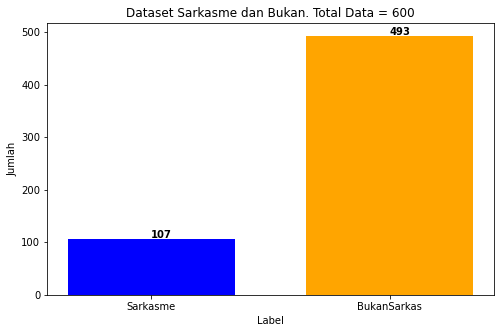

In [5]:
import matplotlib.pyplot as plt

jumlahData=DataTweet["Tweet"].shape[0] #Jumlah Data
jmlSarkas=DataTweet[DataTweet.Label=="Sarkasme"].shape[0]
jmlNonSarkas=DataTweet[DataTweet.Label=="BukanSarkas"].shape[0]
d={'Jumlah': [jumlahData], 'Sarkasme': [jmlSarkas],'BukanSarkas':[jmlNonSarkas]}

cekJumlah = pd.DataFrame(data=d, columns=['Sarkasme','BukanSarkas'])
# creating the dataset
data = {'Sarkasme':jmlSarkas, 'BukanSarkas':jmlNonSarkas}
courses = list(data.keys())
values = list(data.values())
fig = plt.figure(figsize = (8, 5))

# creating the bar plot
plt.bar(courses, values, color ={'orange','blue'} ,width = 0.7)
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.title("Dataset Sarkasme dan Bukan. Total Data = %s" %jumlahData)
for x, y in enumerate(values):
    plt.text(x , y + 2, str(y),color = 'black', fontweight = 'bold')
plt.show()

## Import Library Python
Lakukan import semua library yang dibutuhkan.

In [6]:
import re,string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import pickle

## Text Preprocessing

Data teks termasuk data yang tidak terstruktur, sehingga diperlukan untuk mengubah data menjadi bentuk yang terstruktur, oleh karena itu proses tersebut adalah Text Preprocessing.

**Fungsi yang saya buat untuk text-preprocessing**

In [9]:
def lower(text):
    # lowercase
    lower = text.lower()
    return lower

def removeURLemoji(text):
    # hapus hastag/mention
    HastagRT = re.sub(r"#(\w+)|@(\w+)|(\brt\b)", " ", text)
    # hapus URL
    pola_url = r'http\S+'
    CleanURL = re.sub(pola_url, " ", HastagRT)
    # hapus emoticon
    hps_emoji = hapus_emoticon(CleanURL)
    # hapus multiWhitespace++, ex: ahh   haa
    text = re.sub('\s+', ' ', hps_emoji)
    # hasil akhir casefolding
    hasil = text
    return hasil

def angkadua(teksAwal2):
    final2 = []
    huruf2 = ""
    for x in range(len(teksAwal2)):
        cek2 = [i for i in teksAwal2[x]]
        for x in range(len(cek2)):
            if x == 0:
                final2.append(cek2[0])
                huruf2 = cek2[0]
            else:
                if cek2[x] != huruf2:
                    if cek2[x] == "2":
                        if(len(final2)) == 2:
                            final2.append(cek2[x-2])
                            final2.append(cek2[x-1])
                            huruf2 = cek2[x]
                        elif(len(final2) > 2):
                            jo = "".join(cek2[:2])
                            if(jo == "se" or jo == "di"):
                                final2.append(" ")
                                final2 = final2+cek2[2:x]
                                huruf2 = cek2[x]
                            else:
                                final2.append(" ")
                                final2 = final2+cek2[:x]
                                huruf2 = cek2[x]
                        else:
                            final2.append(cek2[x])
                            huruf2 = cek2[x]
                    else:
                        final2.append(cek2[x])
                        huruf2 = cek2[x]
                else:
                    final2.append(cek2[x])
                    huruf2 = cek2[x]
        final2.append(" ")
    hasil = "".join(final2).split()
    return hasil


def hapus_hurufganda(teksAwal):
    jml = 0

    final = []
    huruf = ""
    for x in range(len(teksAwal)):
        cek = [i for i in teksAwal[x]]
        for x in range(len(cek)):
            if x == 0:
                final.append(cek[0])
                huruf = cek[0]
                jml = 1
            else:
                if cek[x] != huruf:
                    final.append(cek[x])
                    huruf = cek[x]
                    jml = 1
                else:
                    if jml < 2:
                        final.append(cek[x])
                        huruf = cek[x]
                        jml += 1
        final.append(" ")
    hasil = "".join(final).split()
    return hasil


def hapus_simbolAngka(text):
    del_angkadua = angkadua(text)
    del_hrfganda = hapus_hurufganda(del_angkadua)

    # hasil=[]
    token = del_hrfganda
    lte = ["2g", "3g", "4g", "5g"]
    for i in range(len(token)):
        if(token[i] not in lte):
            token[i] = re.sub(r"\d+", " ", token[i])

    for ele in range(len(token)):
        token[ele] = token[ele].translate(
            str.maketrans('', '', string.punctuation))
        token[ele] = re.sub('\W', "", token[ele])
        token[ele] = re.sub('\s+', "", token[ele])

    return token


def hapus_simbolAngka2(text):
    token = text
    for i in range(len(token)):
        cekG = re.match(r"([\b234]+g)", token[i])
        if (cekG) == None:
            token[i] = re.sub(r"\d+", "", token[i])
    # initializing punctuations string
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

    # Removing punctuations in string
    # Using loop + punctuation string
    for ele in token:
        if ele in punc:
            token = token.replace(ele, " ")
            token = re.sub('\s+', ' ', token)
    return token


def hapus_emoticon(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    # hapus emoji
    CleanEmoji = re.sub(emoji_pattern, "", text)
    return CleanEmoji


def tokenize(kalimat):
    return word_tokenize(kalimat)


def listokalimat(kalimat):
    listToStr = ' '.join(kalimat)
    return listToStr


def delstopwordID(teks):
    notsinglechar=[]
    for kata in teks:
        a = re.sub(r"\b[a-zA-Z]\b", " ", kata)
        if(a!=" "):
            notsinglechar.append(a)
    return [kata for kata in notsinglechar if kata not in list_stopwords]


def daftarStopword():
    list_stopwords = stopwords.words('indonesian')
    # baca tambahan
    my_file = open("_stopwordTambahan.txt", "r")
    tambahan = my_file.read()
    daftar = tambahan.replace('\n', ' ').split()
    ####
    list_stopwords.extend(daftar)
    list_stopwords = set(list_stopwords)
    return list_stopwords


def normal_term():
    normalisasi_word = pd.read_excel("_normalisasi.xlsx")
    normalisasi_dict = {}
    for index, row in normalisasi_word.iterrows():
        if row[0] not in normalisasi_dict:
            normalisasi_dict[row[0]] = row[1]
    return normalisasi_dict


def normalisasi(document):
    kalimat = document
    for term in range(len(kalimat)):
        if kalimat[term] in normalisasi_dict:
            kalimat[term] = normalisasi_dict[kalimat[term]]
    hasil = " ".join(kalimat).split()
    return hasil


def stemming(kalimat):
    term_dict = {}
    for kata in kalimat:
        for term in kalimat:
            if term not in term_dict:
                term_dict[term] = " "
    temp = list(term_dict)
    for x in range(len(temp)):
        if temp[x] == "jaringan":
            term_dict[temp[x]] = temp[x]
        elif temp[x] == "teh" and temp[x+1] == "anget":
            term_dict[temp[x]] = temp[x]
        else:
            term_dict[temp[x]] = stemmer.stem(temp[x])
    kalimat = [term_dict[term] for term in kalimat]
    #listToStr = ' '.join([str(i) for i in kalimat])
    return kalimat


list_stopwords = daftarStopword()
term_dict = {}
factory = StemmerFactory()
stemmer = factory.create_stemmer()
normalisasi_dict = normal_term()


***Text Preprocessing terdiri dari beberapa tahapan:***
1. Casefolding
Proses untuk mengubah semua huruf yang ada pada dokumen teks menjadi huruf kecil
2. Cleaning
Proses pembersihan karakter-karakter yang tidak diperlukan untuk mengurangi noise, seperti angka, URL, simbol yang tidak digunakan.
3. Tokenisasi
Pada dasarnya tokenisasi berarti memecah teks kalimat menjadi potongan kata, atau frasa yang disebut token.
4. Normalisasi
Proses pengubahan bentuk kata yang tidak baku atau ambigu, dan kata dengan huruf berulang-ulang yang terdapat pada dokumen teks menjadi kata yang baku. Misalnya “manisss” diubah jadi “manis”.
5. Konversi kata gaul (Slang Word)
Proses pengubahan kata gaul menjadi kata yang baku sesuai standar KBBI. Dalam sosial media twitter orang Indonesia terkadang menulis kata gaul pada pesan teks mereka. Sehingga untuk mengubah bentuk menjadi kata yang baku, dibutuhkan sebuah daftar kata gaul sesuai dengan yang sering digunakan pada pesan teks. Misalnya “gw” diubah jadi “saya”, “napa” diubah jadi “kenapa” dan lain sebagainya.

### Casefolding dan Cleaning
Pada pesan teks berbahasa Indonesia dari media sosial, orang sering kali menggunakan kata-kata tidak baku dari pada kata baku seperti menggunakan angka untuk mengganti alfabet, kata singkatan, karakter yang berulang, dan kata gaul. Oleh karena itu harus dilakukan tahapan preprocessing terlebih dahulu agar jadi lebih terstruktur. Selain itu akan dihilangkan tanda baca yang tidak perlu, URL yang ada dalam teks.

In [10]:
def lowRemoveURL(text):
    #lowercase
    lower=text.lower()
    #hapus hastag/mention
    HastagRT=re.sub(r"#(\w+)|@(\w+)|(\brt\b)"," ", lower)
    #hapus URL
    pola_url = r'http\S+'
    CleanURL=re.sub(pola_url," ", HastagRT)
    #hapus emoticon
    hps_emoji=hapus_emoticon(CleanURL)
    #hapus multiWhitespace++, ex: ahh   haa
    text = re.sub('\s+',' ',hps_emoji)
    #hasil akhir casefolding
    hasil=text
    return hasil

#============== Start Processing Text
print("\n##-------- Mulai Proses Preprocessing --------##\n")
print('\n...... Proses Casefolding lowercase, hapus URL...... ')
DataTweet['casefolding1'] = DataTweet['Tweet'].apply(lowRemoveURL)
DataTweet


##-------- Mulai Proses Preprocessing --------##


...... Proses Casefolding lowercase, hapus URL...... 


,Tweet,Label,casefolding1
0,"@mopuci @collegemenfess Mjb, indogsat 100k 50g...",Sarkasme,"mjb, indogsat 100k 50gb. jaringan lebih ok ju..."
1,ini jaringan pas wiken knp kenceng pakee bgttt...,Sarkasme,ini jaringan pas wiken knp kenceng pakee bgttt...
2,@MNCPlayID sudah lebih dari 16 jam layanan int...,BukanSarkas,sudah lebih dari 16 jam layanan internet dan ...
3,⁦@IndiHome⁩ lapor di daerah sukatani tapos dep...,BukanSarkas,⁦ ⁩ lapor di daerah sukatani tapos depok serin...
4,"indosat ngntd kmpa si, ada jaringan tpi browse...",BukanSarkas,"indosat ngntd kmpa si, ada jaringan tpi browse..."
...,...,...,...
595,Kirain jam segini jaringan baguss,BukanSarkas,kirain jam segini jaringan baguss
596,"@gengysi w kirain jaringan lemot, ternyata....🤣🤣😝",BukanSarkas,"w kirain jaringan lemot, ternyata...."
597,"gedek bgt gue, jaringan tiba² ilang pas lagi u...",BukanSarkas,"gedek bgt gue, jaringan tiba² ilang pas lagi u..."
598,@FirstMediaCares Tidak ada jaringan min dari j...,BukanSarkas,tidak ada jaringan min dari jam 12 offline


### Tokenisasi
Tokenisasi adalah tahapan dari teks pre-processing yang memiliki tujuan untuk memisahkan setiap teks dalam dataset menjadi potongan-potongan kata yang disebut token.

In [11]:
#==== Tokenisasi : memisahkan kata dalam kalimat
print('\n...... Tokenisasi ...... ')
DataTweet['Tokenisasi'] = DataTweet['casefolding1'].apply(tokenize)
DataTweet[['casefolding1','Tokenisasi']].head(13)


...... Tokenisasi ...... 


,casefolding1,Tokenisasi
0,"mjb, indogsat 100k 50gb. jaringan lebih ok ju...","[mjb, ,, indogsat, 100k, 50gb, ., jaringan, le..."
1,ini jaringan pas wiken knp kenceng pakee bgttt...,"[ini, jaringan, pas, wiken, knp, kenceng, pake..."
2,sudah lebih dari 16 jam layanan internet dan ...,"[sudah, lebih, dari, 16, jam, layanan, interne..."
3,⁦ ⁩ lapor di daerah sukatani tapos depok serin...,"[⁦, ⁩, lapor, di, daerah, sukatani, tapos, dep..."
4,"indosat ngntd kmpa si, ada jaringan tpi browse...","[indosat, ngntd, kmpa, si, ,, ada, jaringan, t..."
5,males mau bobo lagi jaringan ngajak kelahi,"[males, mau, bobo, lagi, jaringan, ngajak, kel..."
6,hawa dingin habis hujan ditambah jaringan lem...,"[hawa, dingin, habis, hujan, ditambah, jaringa..."
7,"jaringan aku dsini lemot banget, padahal masi...","[jaringan, aku, dsini, lemot, banget, ,, padah..."
8,"jaringan ama web gw kenapa si ngeselin banget,...","[jaringan, ama, web, gw, kenapa, si, ngeselin,..."
9,"halo byu, sudah hampir 3 minggu ini sinyal da...","[halo, byu, ,, sudah, hampir, 3, minggu, ini, ..."


In [12]:
print('\n...... Proses Casefolding2 hapus angka dan simbol...... ')
DataTweet['casefolding2'] = DataTweet['Tokenisasi'].apply(hapus_simbolAngka)
DataTweet[['casefolding2']].head(12)


...... Proses Casefolding2 hapus angka dan simbol...... 


,casefolding2
0,"[mjb, , indogsat, k, gb, , jaringan, lebih, ok..."
1,"[ini, jaringan, pas, wiken, knp, kenceng, pake..."
2,"[sudah, lebih, dari, , jam, layanan, internet,..."
3,"[, , lapor, di, daerah, sukatani, tapos, depok..."
4,"[indosat, ngntd, kmpa, si, , ada, jaringan, tp..."
5,"[males, mau, bobo, lagi, jaringan, ngajak, kel..."
6,"[hawa, dingin, habis, hujan, ditambah, jaringa..."
7,"[jaringan, aku, dsini, lemot, banget, , padaha..."
8,"[jaringan, ama, web, gw, kenapa, si, ngeselin,..."
9,"[halo, byu, , sudah, hampir, , minggu, ini, si..."


### Normalisasi
Dalam media sosial twitter orang Indonesia terkadang menulis kata gaul dan kata yang tidak baku, bahkan sering kali ada kata-kata yang salah dalam penulisannya, sehingga diperlukan untuk mengubahnya menjadi kata yang baku sesuai dengan KBBI pada tahapan text pre-processing, hal tersebut dapat disebut dengan normalisasi.

In [13]:
#============== Normalisasi: kata gaul, singkatan jadi kata baku
print('\n...... Proses Normalisasi ...... ')
DataTweet['Normalisasi'] = DataTweet['casefolding2'].apply(normalisasi)
DataTweet[['casefolding2','Normalisasi']].head(12)


...... Proses Normalisasi ...... 


,casefolding2,Normalisasi
0,"[maaf gabung bareng, , indosat, ribu, gigabyte...","[maaf, gabung, bareng, indosat, ribu, gigabyte..."
1,"[ini, jaringan, waktu, minggu, kenapa, cepat, ...","[ini, jaringan, waktu, minggu, kenapa, cepat, ..."
2,"[sudah, lebih, dari, , jam, layanan, internet,...","[sudah, lebih, dari, jam, layanan, internet, d..."
3,"[, , lapor, di, daerah, sukatani, tapos, depok...","[lapor, di, daerah, sukatani, tapos, depok, se..."
4,"[indosat, ngentot, kenapa, sih, , ada, jaringa...","[indosat, ngentot, kenapa, sih, ada, jaringan,..."
5,"[malas, mau, tidur, lagi, jaringan, ngajak, ke...","[malas, mau, tidur, lagi, jaringan, ngajak, ke..."
6,"[hawa, dingin, habis, hujan, ditambah, jaringa...","[hawa, dingin, habis, hujan, ditambah, jaringa..."
7,"[jaringan, aku, disini, lambat, banget, , pada...","[jaringan, aku, disini, lambat, banget, padaha..."
8,"[jaringan, sama, web, aku, kenapa, sih, ngesel...","[jaringan, sama, web, aku, kenapa, sih, ngesel..."
9,"[halo, telkomsel, , sudah, hampir, , minggu, i...","[halo, telkomsel, sudah, hampir, minggu, ini, ..."


### Stopword Removal
Pada tahapan ini bertujuan untuk membersihkan teks dari kata yang sangat sering digunakan sehingga muncul dalam jumah besar dan kata yang dianggap tidak memiliki makna, seperti kata ganti, penghubung dan karakter satu huruf yang tidak memiliki arti.

In [14]:
#==== Stopword Removal : hapus kata yang tidak terlalu penting
print('\n...... Proses Stopword Removal ...... ')
DataTweet['Stopword'] = DataTweet['Normalisasi'].apply(delstopwordID)
DataTweet[['Stopword']].head(6)


...... Proses Stopword Removal ...... 


,Stopword
0,"[maaf, gabung, bareng, indosat, ribu, gigabyte..."
1,"[jaringan, minggu, cepat, pakai, banget, oi, g..."
2,"[jam, layanan, internet, televisi, jaringan]"
3,"[lapor, daerah, sukatani, tapos, depok, indiho..."
4,"[indosat, ngentot, sih, jaringan, browser, jalan]"
5,"[malas, tidur, jaringan, ngajak, kelahi]"


## Stemming
Stemming adalah tahapan dari teks pre-processing yang memiliki tujuan untuk mereduksi kata ke dalam bentuk akar atau bentuk kata dasarnya. Stemming akan mengubah kata menjadi kata dasarnya dengan menghilangkan semua imbuhan yang terdiri dari awalan, sisipan dan akhiran.

In [15]:
#==== Stemming : mengurangi dimensi fitur kata/term
print('\n................ Proses Stemming ................ ')
DataTweet['Stemmed'] = DataTweet['Stopword'].apply(stemming)
print(DataTweet['Stemmed'].head(3))
DataTweet['newTweet'] = DataTweet['Stemmed'].apply(listokalimat)
print('\n==========')
DataTweet['newTweet'].head(12)


................ Proses Stemming ................ 
0    [maaf, gabung, bareng, indosat, ribu, gigabyte...
1    [jaringan, minggu, cepat, pakai, banget, oi, g...
2           [jam, layan, internet, televisi, jaringan]
Name: Stemmed, dtype: object



0     maaf gabung bareng indosat ribu gigabyte jarin...
1     jaringan minggu cepat pakai banget oi gilir ku...
2                  jam layan internet televisi jaringan
3     lapor daerah sukatani tapos depok indihome min...
4            indosat ngentot sih jaringan browser jalan
5                    malas tidur jaringan ngajak kelahi
6     hawa dingin habis hujan tambah jaringan lambat...
7                           jaringan lambat banget pagi
8            jaringan web sih ngeselin banget coba coba
9     halo telkomsel minggu sinyal jaringan internet...
10         haha kirim tweet malam emang anjing jaringan
11              gilir uji laptop jaringan lambat anjing
Name: newTweet, dtype: object

## Vektorisasi (TF-IDF)

Setelah selesai dalam tahap teks preprocessing, data yang dihasilkan masih berupa token potongan-potongan kata yang tidak dapat langsung diproses oleh mesin untuk dilanjutkan tahap klasifikasi. Oleh karena itu diperlukan proses vektorisasi yang berguna untuk mengubah kata menjadi angka dan disusun dalam bentuk matriks dengan cara menghitung berapa kali kemunculan kata pada setiap tweet dalam dokumen yang biasa disebut pembobotan kata. Proses pembobotan kata yang paling umum digunakan adalah menggunakan TF-IDF. Hasil penerapan pembobotan kata dengan TF-IDF ditampilkan sebagai berikut:

In [61]:
#====================== lakukan TF-IDF
print('\n................ Hitung TF-IDF ................ ')
tfidf_vect = TfidfVectorizer()
vect_docs = tfidf_vect.fit_transform(DataTweet['newTweet'])
#print(vect_docs)
features_names = tfidf_vect.get_feature_names_out()

datane = []
means=vect_docs.mean(axis=0)
for col, term in enumerate(features_names):
    datane.append( (term, means[0,col] ))

ranking = pd.DataFrame(datane, columns=['term','rata2bobot'])
ranking = ranking.sort_values('rata2bobot', ascending=False)
print(ranking.head(7))

dense = vect_docs.todense()
alist = dense.tolist()
print('\n================')
newData = pd.DataFrame(alist,columns=features_names)
newData


................ Hitung TF-IDF ................ 
         term  rata2bobot
331  jaringan    0.113028
340     jelek    0.051901
73     banget    0.048090
426    lambat    0.035820
861        ya    0.030943
313  internet    0.028287
306  indihome    0.027122



,aba,abad,adik,admin,administrator,aduh,ah,ahli,aja,ajak,...,wkwkwk,wow,xd,xl,ya,yakxd,yaudah,youtube,yuk,zoom
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.235527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,0.0,0.0,0.0,0.473133,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## SMOTE
Ketidakseimbangan kelas (imbalance class) dapat mengganggu kemampuan prediksi algoritma klasifikasi karena algoritma mengejar
akurasi klasifikasi secara keseluruhan. Data dikatakan seimbang apabila perbandingan antara kedua kelas adalah 1:1. Masalah kelas data yang tidak simbang dapat berakibat pada ketepatan klasifikasi kelas minoritas. 

Untuk memecahkan masalah klasifikasi yang sulit ketika berhadapan dengan kumpulan data yang tidak seimbang, dapat menggunakan metode menyeimbangkan jumlah data pada kelas yang berbeda dengan menambahkan sampel ke kelas minoritas (oversampling) atau menghapus sampel dari kelas mayoritas (undersampling). Berikut adalah penerapan SMOTE.

fold-berjumlah: 10
Jumlah Data latih sebelum SMOTE = 540
Sarkasme = 93 BukanSarkas = 447
Jumlah Data latih setelah SMOTE = 894
Sarkasme = 447 BukanSarkas = 447
Jumlah Data Uji = 60


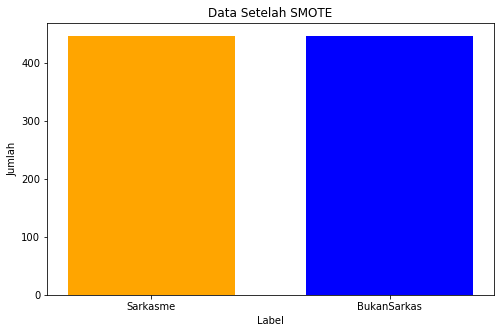

In [69]:
x = newData.iloc[:]
y= DataTweet["Label"]
#print('\nK - Fold Cross Validation')
k=10
kf = KFold(n_splits=k)
print("fold-berjumlah:",k)
kfold=[]
temp_akurasi = []
temp_pres = []
temp_recall = []
temp_f1 = []
temp_model=[]
it=0
for train_index , test_index in kf.split(x):
    X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
   
    sm = SMOTE(sampling_strategy="minority",k_neighbors=5)
    x_oversample, y_oversample = sm.fit_resample(X_train, y_train)
    
    if(it==1):
        #setelah resampling dengan SMOTE
        jumlah_awal = y_train.shape[0]
        cekLabel_awal = Counter(y_train)
        jumlah_sm = y_oversample.shape[0]
        cekLabel_sm = Counter(y_oversample)
        jumlah_tes = y_test.shape[0]
        print('Jumlah Data latih sebelum SMOTE =', jumlah_awal)
        print('Sarkasme =', cekLabel_awal['Sarkasme'],'BukanSarkas =',cekLabel_awal['BukanSarkas'])
        print('Jumlah Data latih setelah SMOTE =', jumlah_sm)
        print('Sarkasme =', cekLabel_sm['Sarkasme'],'BukanSarkas =',cekLabel_sm['BukanSarkas'])
        print('Jumlah Data Uji =', jumlah_tes)
        # creating the dataset
        data = {'Sarkasme':cekLabel_sm['Sarkasme'], 'BukanSarkas':cekLabel_sm['BukanSarkas']}
        courses = list(data.keys())
        values = list(data.values())
        fig = plt.figure(figsize = (8, 5))
         
        # creating the bar plot
        plt.bar(courses, values, color ={'orange','blue'} ,width = 0.7)
        plt.xlabel("Label")
        plt.ylabel("Jumlah")
        plt.title("Data Setelah SMOTE")
        plt.show()
    it=it+1


***Sebelum dilakukan SMOTE***

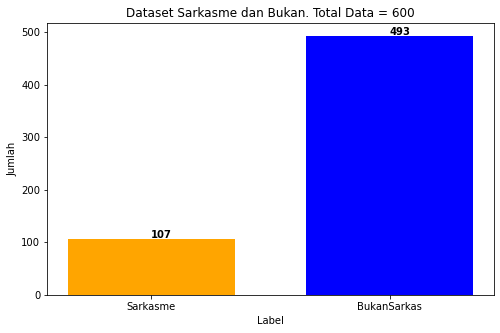

In [70]:
jumlahData=DataTweet["Tweet"].shape[0] #Jumlah Data
jmlSarkas=DataTweet[DataTweet.Label=="Sarkasme"].shape[0]
jmlNonSarkas=DataTweet[DataTweet.Label=="BukanSarkas"].shape[0]
d={'Jumlah': [jumlahData], 'Sarkasme': [jmlSarkas],'BukanSarkas':[jmlNonSarkas]}

cekJumlah = pd.DataFrame(data=d, columns=['Sarkasme','BukanSarkas'])
# creating the dataset
data = {'Sarkasme':jmlSarkas, 'BukanSarkas':jmlNonSarkas}
courses = list(data.keys())
values = list(data.values())
fig = plt.figure(figsize = (8, 5))

# creating the bar plot
plt.bar(courses, values, color ={'orange','blue'} ,width = 0.7)
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.title("Dataset Sarkasme dan Bukan. Total Data = %s" %jumlahData)
for x, y in enumerate(values):
    plt.text(x , y + 2, str(y),color = 'black', fontweight = 'bold')
plt.show()

## Classification
### Cross Validation
Proses pembentukan model klasifikasi dilakukan dengan bantuan metode evaluasi Validasi silang atau Cross Validation, yang merupakan pendekatan yang populer digunakan untuk evaluasi kinerja untuk pengklasifikasi. Pendekatan umumnya adalah bahwa model dilatih beberapa kali dan untuk setiap kali satu bagian dari keseluruhan diperlakukan sebagai data evaluasi sedangkan sisanya digunakan untuk pelatihan.

Metode ini membagi dataset menjadi K bagian yang disebut folds, dengan ukuran yang sama. Setiap fold hanya satu dari N sampel data digunakan untuk tujuan validasi, dan sisanya digunakan sebagai data latih. Proses ini akan diulang sebanyak N kali dan hasil akhirnya adalah rata-rata.

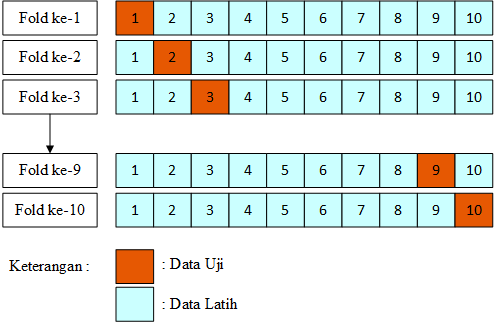

### Training Model
Tahapan berikutnya adalah proses klasifikasi menggunakan gabungan metode Support Vector Machine dan metode Ensemble (AdaBoost) untuk deteksi sarkasme, apakah teks tersebut termasuk sarkasme atau bukan sarkasme.

In [75]:
x = newData.iloc[:]
y= DataTweet["Label"]

print('\n================ Model ================ ')
print('\n================ Pembagian data Training dan Testing ================ ')
#============================ K-fold Start
print('\nK - Fold Cross Validation')
k=5
kf = KFold(n_splits=k)
print("fold-berjumlah:",k)
kfold=[]
temp_akurasi = []
temp_pres = []
temp_recall = []
temp_f1 = []
temp_model=[]

it=1
TP = 0
FP = 0
TN = 0
FN = 0

start = timer()
for train_index , test_index in kf.split(x):
    startT = timer()
    X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
    print(len(X_train.columns))
    print('\n================ Fold ke -',it)
    #print('Data Train\n',X_train)
    #print('Data Test\n',X_test)
    startS = timer()
    
    sm = SMOTE(sampling_strategy="minority",k_neighbors=5)
    x_oversample, y_oversample = sm.fit_resample(X_train, y_train)
    
    endS = timer()
    waktu=endS - startS
    print("Waktu Eksekusi SMOTE= ",waktu,"detik atau",waktu/60,"menit")
    
    #setelah resampling dengan SMOTE
    jumlah_awal = y_train.shape[0]
    cekLabel_awal = Counter(y_train)
    jumlah_sm = y_oversample.shape[0]
    cekLabel_sm = Counter(y_oversample)
    jumlah_tes = y_test.shape[0]
    print('Jumlah Data latih sebelum SMOTE =', jumlah_awal)
    print('Sarkasme =', cekLabel_awal['Sarkasme'],'BukanSarkas =',cekLabel_awal['BukanSarkas'])
    print('Jumlah Data latih setelah SMOTE =', jumlah_sm)
    print('Sarkasme =', cekLabel_sm['Sarkasme'],'BukanSarkas =',cekLabel_sm['BukanSarkas'])
    print('Jumlah Data Uji =', jumlah_tes)
    #================== Metode klasifikasi
    baseLearn_svm=SVC(probability=True,kernel='linear')
    print('\nMetode Adaboost SVM')
    model_adaboost =AdaBoostClassifier(n_estimators=30, base_estimator=baseLearn_svm,learning_rate=0.5)
    model_adaboost.fit(x_oversample,y_oversample)
    Prediksi = model_adaboost.predict(X_test)
    #add to list model
    temp_model.append(model_adaboost)
    #=================
    ceklah = pd.DataFrame(columns=['Tweet_Split','Label_Split','Label_Prediksi'])
    ceklah['newTweet'] = DataTweet['Tweet'].iloc[test_index]
    ceklah['Label'] = DataTweet['Label'].iloc[test_index]
    ceklah['LabelPrediksi'] = Prediksi
    
    endT = timer()
    waktu=endT - startT
    print("Waktu Eksekusi Training Test= ",waktu,"detik atau",waktu/60,"menit")
    
    jumlahtes = ceklah.shape[0]
    positif="Sarkasme"
    negatif="BukanSarkas"
    for i in range(jumlahtes):
        cek=ceklah.iloc[i]
        if (cek.Label==positif and cek.LabelPrediksi==positif):
            TP+=1
        elif(cek.Label==positif and cek.LabelPrediksi==negatif):
            FN+=1
        elif(cek.Label==negatif and cek.LabelPrediksi==negatif):
            TN+=1
        elif(cek.Label==negatif and cek.LabelPrediksi==positif):
            FP+=1
    
    print("(TP) TruePositif :",TP,"\n(FP) FalsePositif :",FP,"\n(TN) TrueNegatif :",TN,"\n(FN) FalseNegatif :",FN)
    #akurasi
    akurasi=(TP+TN)/(TP+FP+TN+FN)
    #presisi
    cek0 = TP+FP
    if(cek0==0):
        presisi=0
    else:
        presisi=TP/(TP+FP)
    #recall
    cek1 = TP+FN
    if(cek1==0):
        recal=0
    else:
        recal=TP/(TP+FN)
    
    if(presisi==0 and recal==0):
        f1=0
    else:
        f1=(2*presisi*recal)/(presisi+recal)
    hasil_akurasi = round(akurasi*100,3)
    hasil_pres=round(presisi*100,3)
    hasil_recal=round(recal*100,3)
    hasil_f1=round(f1*100,3)
    
    
    temp_akurasi.append(hasil_akurasi)
    temp_pres.append(hasil_pres)
    temp_recall.append(hasil_recal)
    temp_f1.append(hasil_f1)
    print('Akurasi Fold ke -',it,'=',hasil_akurasi)
    print('Presisi Fold ke -',it,'=',hasil_pres)
    print('Recall Fold ke -',it,'=',hasil_recal)
    print('F1-Measure Fold ke -',it,'=',hasil_f1)
    kfold.append([jumlahtes,TP,FP,TN,FN,hasil_akurasi,hasil_pres,hasil_recal,hasil_f1])
    it=it+1
    TP = 0
    FP = 0
    TN = 0
    FN = 0

rata2=0
rata2rec=0
rata2pre=0
rata2f1=0
for x in range(len(temp_akurasi)):
    rata2=rata2+temp_akurasi[x]
print("rata-rata akurasi=",round(rata2/k,3))

end = timer()
waktue = end - start
print("Waktu Eksekusi Training Test= ",waktue,"detik atau",waktue/60,"menit")


================ Model ================ 

================ Pembagian data Training dan Testing ================ 

K - Fold Cross Validation
fold-berjumlah: 5
867

================ Fold ke - 1
Waktu Eksekusi SMOTE=  0.5160977069990622 detik atau 0.008601628449984371 menit
Jumlah Data latih sebelum SMOTE = 480
Sarkasme = 73 BukanSarkas = 407
Jumlah Data latih setelah SMOTE = 814
Sarkasme = 407 BukanSarkas = 407
Jumlah Data Uji = 120

Metode Adaboost SVM
Waktu Eksekusi Training Test=  69.11410175999845 detik atau 1.1519016959999742 menit
(TP) TruePositif : 5 
(FP) FalsePositif : 8 
(TN) TrueNegatif : 78 
(FN) FalseNegatif : 29
Akurasi Fold ke - 1 = 69.167
Presisi Fold ke - 1 = 38.462
Recall Fold ke - 1 = 14.706
F1-Measure Fold ke - 1 = 21.277
867

================ Fold ke - 2
Waktu Eksekusi SMOTE=  0.15926613400006318 detik atau 0.0026544355666677194 menit
Jumlah Data latih sebelum SMOTE = 480
Sarkasme = 83 BukanSarkas = 397
Jumlah Data latih setelah SMOTE = 794
Sarkasme = 397 BukanSarka

## Saving Model with Pickle
Model hasil training sebelumnya dapat disimpan dengan format pickle, model pelatihan dipilih dari data akurasi yang paling tinggi.

In [92]:
#print(temp_model)
maxacc=max(temp_akurasi)
print("MAX akurasi",maxacc)

maxi = temp_akurasi.index(maxacc)
modele=temp_model[maxi]

#simpan model yang memiliki akurasi tertinggi pada cross validation
"""
import os
import os.path
pkl_filename = "pickle_modelF.pkl"
if (os.path.exists(pkl_filename)):
    os.remove(pkl_filename)

with open(pkl_filename,'wb') as file:
    pickle.dump(modele,file)
"""
pickle.dump(tfidf_vect.vocabulary_, open("pickle_featureF.pkl", "wb"))

MAX akurasi 90.0


## Implementasi Model
Model yang tersimpan dapat diimplementasikan untuk mendeteksi data text baru. Tahapannya sama mulai dari text-preprocessing sampai dengan Stemming.

In [33]:
#============== Read Data Input
filetest="#tweet_label_dikit.xlsx"
Prediksites2 = pd.read_excel(filetest)
tes=Prediksites2
#
jumlahData=tes["Tweet"].shape[0] #Jumlah Data
jmlSarkas=tes[tes.Label=="Sarkasme"].shape[0]
jmlNonSarkas=tes[tes.Label=="BukanSarkas"].shape[0]
d={'Jumlah': [jumlahData], 'Sarkasme': [jmlSarkas],'BukanSarkas':[jmlNonSarkas]}

cekJumlah = pd.DataFrame(data=d, columns=['Sarkasme','BukanSarkas'])
print('\n...... Jumlah Data ...... ')
print("Total:",jumlahData)
print(cekJumlah)
#ax = cekJumlah.plot.bar(rot=0)
#============== Start Processing Text
print("\n##-------- Mulai Proses Preprocessing --------##\n")
print('\n...... Proses Casefolding lowercase, hapus URL...... ')
tes['casefolding'] = tes['Tweet'].apply(lower)
tes['removeURL'] = tes['casefolding'].apply(removeURLemoji)
print(tes)

#==== Tokenisasi : memisahkan kata dalam kalimat
print('\n...... Tokenisasi ...... ')
tes['Tokenisasi'] = tes['removeURL'].apply(tokenize)
print(tes[['Tokenisasi']].head(2))

print('\n...... Proses Casefolding2 hapus angka dan simbol...... ')
tes['Cleaning'] = tes['Tokenisasi'].apply(hapus_simbolAngka)
Prediksites2=pd.DataFrame()
Prediksites2['Cleaning']=tes['Cleaning']
print(Prediksites2[['Cleaning']].head(2))
#============== Normalisasi: kata gaul, singkatan jadi kata baku
print('\n...... Proses Normalisasi ...... ')
#normalisasi_dict = normal_term() #import excel
tes['Normalisasi'] = tes['Cleaning'].apply(normalisasi)
print(tes[['Normalisasi']].head(2))

#==== Stopword Removal : hapus kata yang tidak terlalu penting
print('\n...... Proses Stopword Removal ...... ')
#list_stopwords = daftarStopword()
tes['Stopword'] = tes['Normalisasi'].apply(delstopwordID)
print(tes[['Stopword']].head(6))

#==== Stemming : mengurangi dimensi fitur kata/term
print('\n................ Proses Stemming ................ ')
tes['Stemmed'] = tes['Stopword'].apply(stemming)
print(tes['Stemmed'].head(3))
tes['newTweet'] = tes['Stemmed'].apply(listokalimat)


...... Jumlah Data ...... 
Total: 114
   Sarkasme  BukanSarkas
0        24           90

##-------- Mulai Proses Preprocessing --------##


...... Proses Casefolding lowercase, hapus URL...... 
                                                 Tweet        Label  \
0    sedih bgt anjing gue gabisa scroll tl gabisa l...     Sarkasme   
1    By.U ini pakai jaringan @smartfrencare ya min ...  BukanSarkas   
2    Kalo jaringan bagus dan aku gaada kerjaan ya b...  BukanSarkas   
3    RT @NUgarislucu: Termasuk bangkitnya lagi ITJ ...  BukanSarkas   
4    Gue belum dengerin ulang yours💔 tadi kepotong²...  BukanSarkas   
..                                                 ...          ...   
109  PLISS LAGI SERU SERUNYAAA malah hilanh jaringa...  BukanSarkas   
110  @Jaehytun iyaa, ini indosut, tsel, di awa dari...  BukanSarkas   
111      Jaringan telkomsel astagfirulloh,bisa2 ny H+😭  BukanSarkas   
112  @FirstMediaCares Kasian sekali hanya sibuk men...  BukanSarkas   
113                  Kir

### Load Model TF-IDF dan Klasifikasi
Akan ada dua file yang akan digunakan yaitu model dari fitur TF-IDF yang telah tersimpan sesuai dengan model yang dibentuk untuk mentransformasikan teks baru, dan model klasifikasi itu sendiri untuk memprediksi data tersebut.

***Load Model TF-IDF***

In [34]:
print('\n................ Load Model Fitur TF-IDF ................ ')
savedtfidf = pickle.load(open("pickle_featureF.pkl", 'rb'))
vectorizer2 = TfidfVectorizer(vocabulary=savedtfidf)
vect_docs2 = vectorizer2.fit_transform(tes['newTweet'])
features_names2 = vectorizer2.get_feature_names_out()

dense2 = vect_docs2.todense()
alist2 = dense2.tolist()
print('\n================')
newData2 = pd.DataFrame(alist2,columns=features_names2)
print(newData2)



................ Load Model Fitur TF-IDF ................ 

     aba  abad  adik     admin  administrator  aduh   ah      ahli  aja  ajak  \
0    0.0   0.0   0.0  0.000000            0.0   0.0  0.0  0.000000  0.0   0.0   
1    0.0   0.0   0.0  0.542116            0.0   0.0  0.0  0.000000  0.0   0.0   
2    0.0   0.0   0.0  0.000000            0.0   0.0  0.0  0.000000  0.0   0.0   
3    0.0   0.0   0.0  0.000000            0.0   0.0  0.0  0.000000  0.0   0.0   
4    0.0   0.0   0.0  0.000000            0.0   0.0  0.0  0.000000  0.0   0.0   
..   ...   ...   ...       ...            ...   ...  ...       ...  ...   ...   
109  0.0   0.0   0.0  0.000000            0.0   0.0  0.0  0.000000  0.0   0.0   
110  0.0   0.0   0.0  0.000000            0.0   0.0  0.0  0.000000  0.0   0.0   
111  0.0   0.0   0.0  0.000000            0.0   0.0  0.0  0.000000  0.0   0.0   
112  0.0   0.0   0.0  0.000000            0.0   0.0  0.0  0.293638  0.0   0.0   
113  0.0   0.0   0.0  0.000000            0.0   

***Load Model Klasifikasi***

In [35]:
# Load from file

import pickle

with open("pickle_modelF.pkl", 'rb') as file:
    pickle_model = pickle.load(file)
hasil=pickle_model.predict(newData2)
DFpredict = pd.DataFrame(hasil,columns=["Prediksi"])
#print(DFpredict)
gabungkan = pd.concat([tes[['Tweet','Label']], DFpredict], axis=1)
gabungkan


,Tweet,Label,Prediksi
0,sedih bgt anjing gue gabisa scroll tl gabisa l...,Sarkasme,Sarkasme
1,By.U ini pakai jaringan @smartfrencare ya min ...,BukanSarkas,BukanSarkas
2,Kalo jaringan bagus dan aku gaada kerjaan ya b...,BukanSarkas,BukanSarkas
3,RT @NUgarislucu: Termasuk bangkitnya lagi ITJ ...,BukanSarkas,BukanSarkas
4,Gue belum dengerin ulang yours💔 tadi kepotong²...,BukanSarkas,BukanSarkas
...,...,...,...
109,PLISS LAGI SERU SERUNYAAA malah hilanh jaringa...,BukanSarkas,BukanSarkas
110,"@Jaehytun iyaa, ini indosut, tsel, di awa dari...",BukanSarkas,BukanSarkas
111,"Jaringan telkomsel astagfirulloh,bisa2 ny H+😭",BukanSarkas,BukanSarkas
112,@FirstMediaCares Kasian sekali hanya sibuk men...,BukanSarkas,BukanSarkas
